# Банк Метанпром. Анализ оттока клиентов.

**Цели и задачи проекта:**    
- Я в качестве аналитике в компании "Метанпробанк" буду проводить исследовательский анализ данных для определения общих признаков отточных клиентов, и для разработки плана работ для отдела маркетинг по уменьшению оттока.  
- Для анализа буду использовать данные банка, которые включают в себя значения различных признаков о 10000 клиентов банка.    
- В рамках работы планирую рассмотреть корреляцию каждого признака с оттоком, составить общий портрет оттчоных/неотточных клиентов, составить гипотезы относительно причин оттока, и проверить их статистическим анализом. 
- По результатам анализа выделить признаки, которые влияют на отток, провести сегментацию клиентов на основе интервалов значении признаков, и дать рекомендации, как можно снизить отток в том или ином сегменте.

## Установка необходимых библиотек, обзор данных

In [1]:
# загружаем библиотеки

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# загрузим данные и ознакамливаемся с содержимым
df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
df.head()

USERID  score       city gender   age  equity     balance  products  \
0  183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1  146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2  120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3  225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4  157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  EST_SALARY  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

In [3]:
# изучим общую информацию про датафрейм
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


## Обработка данных 

### Привести column names к нижнему регистру

In [4]:
# из общей информации про датафрейм видно что типы данных соответствуют содержащимся в столбцах данным. 
# необходимо заменить названия некоторых столбцов (привести к нижнему регистру)

df.columns = df.columns.str.lower()
df = df.rename(columns = {'userid': 'user_id'})
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

### Проверка на наличие пропусков, выявление возможных причин

In [5]:
# проверка на пропуски
df.isna().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

Пропуски имеются в столбцах age, balance. В столбце age кол-во пропусков небольшое (0,26%), в то время как в balance около 23% данных пропущены. Необходимо определить возможные причины возникновения пропусков, и решить нужно ли заполнять пропуски.

In [6]:
# добавим столбец is_null, в которое маркирует 1 строки, где нет значения по полю 'balance', и смотрим средние 
# значения в двух группах, где разница больше 10%(с пропуском/без пропуска по полю balance)

df['is_null'] = df['balance'].isna()
df_1 = df.drop(['city', 'gender'], axis=1)

names = ['With balance','No balance','Difference']
df_1.groupby('is_null').agg(["mean"]).T\
  .apply(lambda row: pd.concat((
    row,
    pd.Series(0 if (row[0] == 0 or row[1] == 0) else (row[0]-row[1])/row[0])
    )),axis=1)\
  .set_axis(names,axis=1)\
  .query(f'{names[2]} < -.05 or {names[2]} > .05')\
  .style.background_gradient(subset=[names[2]],cmap='vlag',vmin=-1, vmax=1)\
  .format({names[0]:'{:_.2f}',names[1]:'{:_.2f}',names[2]:'{:.1%}'})

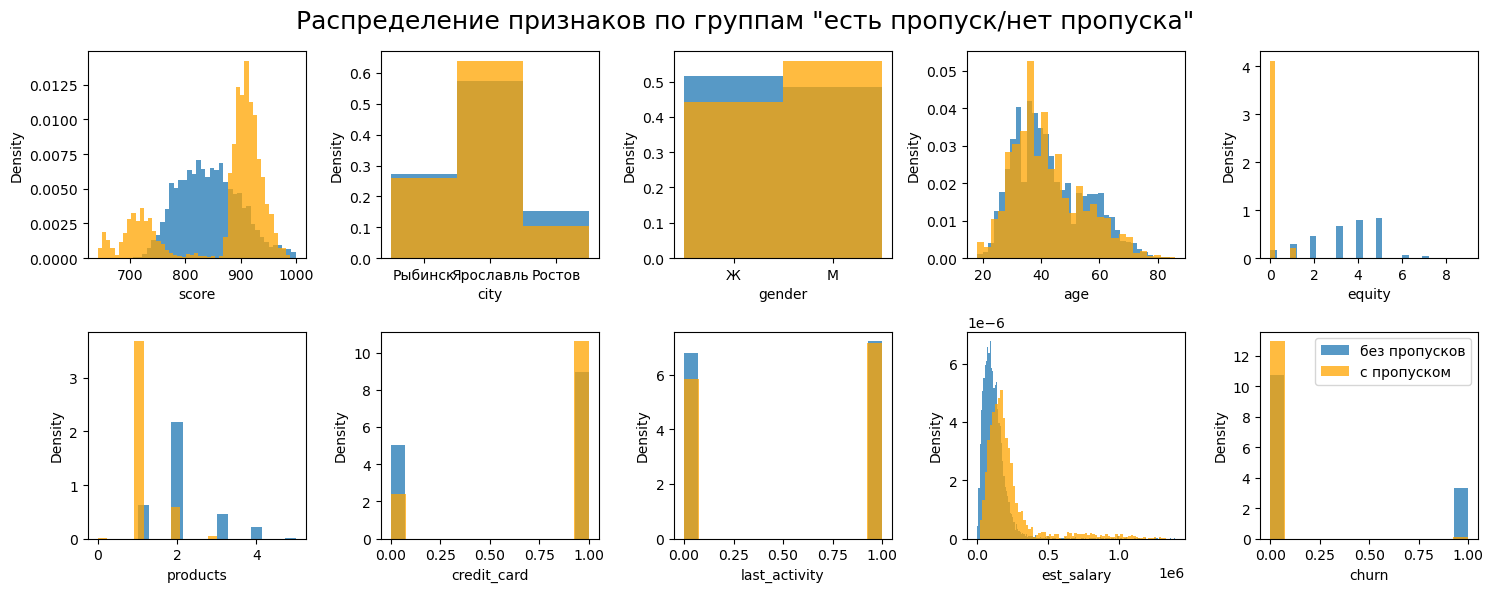

In [7]:
# смотрим распределение признаков по группам "есть пропуск/нет пропуска" для определения возможных закономерностей
df_1 = df.drop(['balance'], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

fig.suptitle('Распределение признаков по группам "есть пропуск/нет пропуска"', fontsize=18)

for ax, feature in zip(axes, df_1.columns[1:11]):
    sns.histplot(df_1[df_1['is_null'] == 0][feature], common_norm=False, stat="density", linewidth=0, ax=ax)
    sns.histplot(df_1[df_1['is_null'] == 1][feature], color="orange", common_norm=False, stat="density", linewidth=0, ax=ax)

plt.legend(["без пропусков", "с пропуском"])
plt.tight_layout()
plt.show()

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Промежуточные выводы</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 

Исходя их средних значении признаков и их плотностного распределения можно заключить что балансы могли быть пропущены у клиентов, которые имеют кредитные продукты:

- у 82% таких клиентов имеются кредитные карты (у группы без пропусков - 64%). 
- распределение по полю score - бимодальное, и пики расположены с двух сторон от среднего значения по всем клиентам. В то время как у остальных клиентов это распределение имеет нормальную форму. Подобное расположение распределении может означать что у этой группы score был откорректирован в зависимости от кредитной истории в лучшую/или худшую сторону
- оценка собственности у группы с пропуском близка к нулю, что может означать что клиенты нуждаются в кредитных средствах банка.
- churn=0.01, группа очень не отточна. Обычно те кто берут кредит остаются на связи с банком пока не расплачиваются с кредитом. 

Если данное предположение верное, то скорее всего у этих клиентов отрицательный баланс в банке, поэтому заполнять эти пропуски считаю не стоит, т.к. заполнение медианными/средними значениями может изменить конечные результаты исследования.

In [8]:
# смотрим средние значения строк с пропусками по полю age
df['is_null'] = df['age'].isna()
display(round(df.groupby('is_null').mean(), 2))

user_id   score    age  equity     balance  products  credit_card  \
is_null                                                                        
False    171755.22  848.68  42.73    2.63   827245.59      1.87         0.68   
True     194637.50  855.15    NaN    1.38  1250033.57      1.35         0.77   

         last_activity  est_salary  churn  
is_null                                    
False             0.52   147786.81   0.18  
True              0.77   178585.20   0.04

Пока сложно что-либо отметить, таких строк всего 26 в датафрейме. Если в дальнейшем не удастся обнаружить какие то закономерности, можно удалить эти строки

### Поиск явных и неявных дубликатов

In [9]:
# проверка на явные/неявные дубликаты
print('кол-во явных дубликатов равно', df.duplicated().sum())
print('кол-во дубликатов по полю user_id равно', df['user_id'].duplicated().sum())

кол-во явных дубликатов равно 0
кол-во дубликатов по полю user_id равно 73


In [10]:
duplicates = df[df.duplicated(subset='user_id', keep=False)]
duplicates.sort_values(by='user_id').head(6)

user_id  score       city gender   age  equity     balance  products  \
1893   116540  883.0    Рыбинск      Ж  55.0       1   362756.49         3   
7694   116540  887.0  Ярославль      Ж  38.0       0         NaN         1   
7542   117943  880.0  Ярославль      Ж  40.0       0         NaN         1   
4866   117943  855.0    Рыбинск      Ж  32.0       6  1036832.93         4   
5896   120258  905.0  Ярославль      М  30.0       0         NaN         1   
5863   120258  908.0    Рыбинск      Ж  38.0       4  2213581.63         2   

      credit_card  last_activity  est_salary  churn  is_null  
1893            0              1   175920.48      1    False  
7694            0              1   119247.61      0    False  
7542            1              0   137718.93      0    False  
4866            1              1   107792.71      1    False  
5896            1              1   146427.96      0    False  
5863            0              1   160327.77      1    False

Обнаружила 73 дубликата по полю user_id. Таких дубликатов в датафрейме не должно быть, так как user_id - уникальный идентификатор клиента. Рассмотрев первые несколько строк можно выделить закономерность - клиент открывал счета в разных городах расположения банка, но при этом сохранил свой идентификатор. При этом в одном из дубликатов поле balance проставляется пропуск. Возможно пропуски в age тоже связаны с этим, что необходимо проверить:

In [11]:
duplicates[duplicates['is_null'] == True]['user_id'].count()

23

23 из 26 пропусков в поле age связаны с подобными дубликатами. Так как природа возникновения пропуска определена, удалим строки дубликаты, содержащие пропуски по age или balance.

In [12]:
# удаляем дубликаты с пропуском по полю age
df = df[~((df['is_null'] == True) & df['user_id'].isin(duplicates['user_id']))]

# удаляем дубликаты с пропуском по полю balance
duplicates = df[df.duplicated(subset='user_id', keep=False)]
df['is_null'] = df.isna().any(axis = 1)
df = df[~((df['is_null'] == True) & df['user_id'].isin(duplicates['user_id']))]

df.shape

(9958, 13)

Остались еще 31 дубликатов по полю user_id. Так как столбца с датой регистрации у нас не имеется, оставшиеся дубликаты удалим по признаку age, оставив строку в большим значением возраста.

In [13]:
# сортируем клиентов по user_id & age по убыванию, и оставляем только первые значения дубликатов

df = df.sort_values(by=['user_id','age'], ascending=False).drop_duplicates(subset='user_id', keep='first')

In [14]:
# оставшиеся пропуски по полю age (3 пропуска) заменяем на медианные значения по гендеру

median_age_by_gender = df.groupby('gender')['age'].transform('median')
df['age'].fillna(median_age_by_gender, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9927 entries, 8913 to 5462
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9927 non-null   int64  
 1   score          9927 non-null   float64
 2   city           9927 non-null   object 
 3   gender         9927 non-null   object 
 4   age            9927 non-null   float64
 5   equity         9927 non-null   int64  
 6   balance        7667 non-null   float64
 7   products       9927 non-null   int64  
 8   credit_card    9927 non-null   int64  
 9   last_activity  9927 non-null   int64  
 10  est_salary     9927 non-null   float64
 11  churn          9927 non-null   int64  
 12  is_null        9927 non-null   bool   
dtypes: bool(1), float64(4), int64(6), object(2)
memory usage: 1017.9+ KB


<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Промежуточные выводы</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Итого: мы удалили 73 строк-дубликатов:
- сначала неполные строки дубликаты с пропущенными значениями age / balance
- остальные пропуски с логикой "учитываем последние данные за корректные"

Заменили оставшиеся пропуски в поле age на медианные значения в разбивке по полу. 

Так же в данных имеются клиенты с кол-вом продуктов = 0, и со значением churn=1. Возможно данный клиент закрыл все имеющиеся продукты и решил покинуть наш банк, но его данные еще не были удалены с баз данных. Так как мы разрабатываем стратегию удержания для уходящих клиентов, данного клиента можно удалить из датафрейма. 

In [15]:
display(df[df['products'] == 0])
df = df[df['products'] != 0]

df = df.drop(columns=['is_null'])

df.shape

user_id  score     city gender   age  equity  balance  products  \
8957   147837  962.0  Рыбинск      Ж  79.0       3      NaN         0   

      credit_card  last_activity  est_salary  churn  is_null  
8957            0              0    25063.96      1     True

(9926, 12)

### Кодирование столбцов gender, city

In [16]:
# проверим уникальные значения в столбце gender:

df['gender'].unique()

array(['Ж', 'М'], dtype=object)

In [17]:
# проверим уникальные значения в столбце city

df['city'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов'], dtype=object)

Поля gender, city содержат ожидаемые 2, 3 уникальных сначении соответственно. С помощью метода get_dummies оцифруем значения этих столбцов в отдельных столбцах.

In [18]:
df['city_2'] = df['city']
df['gender_2'] = df['gender']

df = pd.get_dummies(df, columns=['gender_2'], drop_first=True) # M - 1, Ж - 0
df = pd.get_dummies(df, columns=['city_2'])

# переименуем столбцы в соотвествии с правилами хорошего тона:
df = df.rename(columns = {'gender_2_М': 'gender_codes',
                         'city_2_Ростов': 'rostov',
                         'city_2_Рыбинск': 'rybinsk',
                         'city_2_Ярославль': 'jaroslavl'})
df.head()

user_id  score       city gender   age  equity     balance  products  \
8913   229145  698.0  Ярославль      Ж  37.0       0         NaN         1   
1234   229136  883.0    Рыбинск      Ж  38.0       3   342099.90         2   
6059   229130  828.0  Ярославль      Ж  44.0       2   168323.87         2   
5764   229058  875.0  Ярославль      М  54.0       4  3680351.98         3   
2373   229054  883.0  Ярославль      М  27.0       0         NaN         1   

      credit_card  last_activity  est_salary  churn  gender_codes  rostov  \
8913            1              1   255439.00      0             0       0   
1234            1              0    80587.26      0             0       0   
6059            1              1   163995.10      0             0       0   
5764            0              1   173790.63      1             1       0   
2373            1              1   144948.73      0             1       0   

      rybinsk  jaroslavl  
8913        0          1  
1234        1          0  
6059        0          1  
5764        0          1  
2373        0          1

## Исследовательский анализ данных (EDA)

###  Рассчитать средние значения признаков в двух группах: отточные/не отточные

In [19]:
print('Средний churn rate банка - ', round(df['churn'].sum()/len(df), 2))

Средний churn rate банка -  0.18


In [20]:
# Рассчитать средние значения признаков в двух группах: отточные/не отточные

df_1 = df.drop(['city', 'gender', 'rybinsk'], axis=1)

names = ['retention','churn','difference']
df_1.groupby('churn').agg(["mean"]).T\
  .apply(lambda row: pd.concat((
    row,
    pd.Series(0 if (row[0] == 0 or row[1] == 0) else (row[1]-row[0])/row[1])
    )),axis=1)\
  .set_axis(names,axis=1)\
  .query(f'{names[2]} < -.05 or {names[2]} > .05')\
  .style.background_gradient(subset=[names[2]],cmap='vlag',vmin=-1, vmax=1)\
  .format({names[0]:'{:_.2f}',names[1]:'{:_.2f}',names[2]:'{:.1%}'})

по средним значениям признаков по оттоку (churn=0/1) у отточных:

- equity  - выше
- balance - выше
- products - больше
- credit card - меньше кредитных карт
- last activity - более активны
- gender codes (1-M, 0-F) - мужчин больше

### Построить столбчатые гистограммы распределения по группам отток/удержание

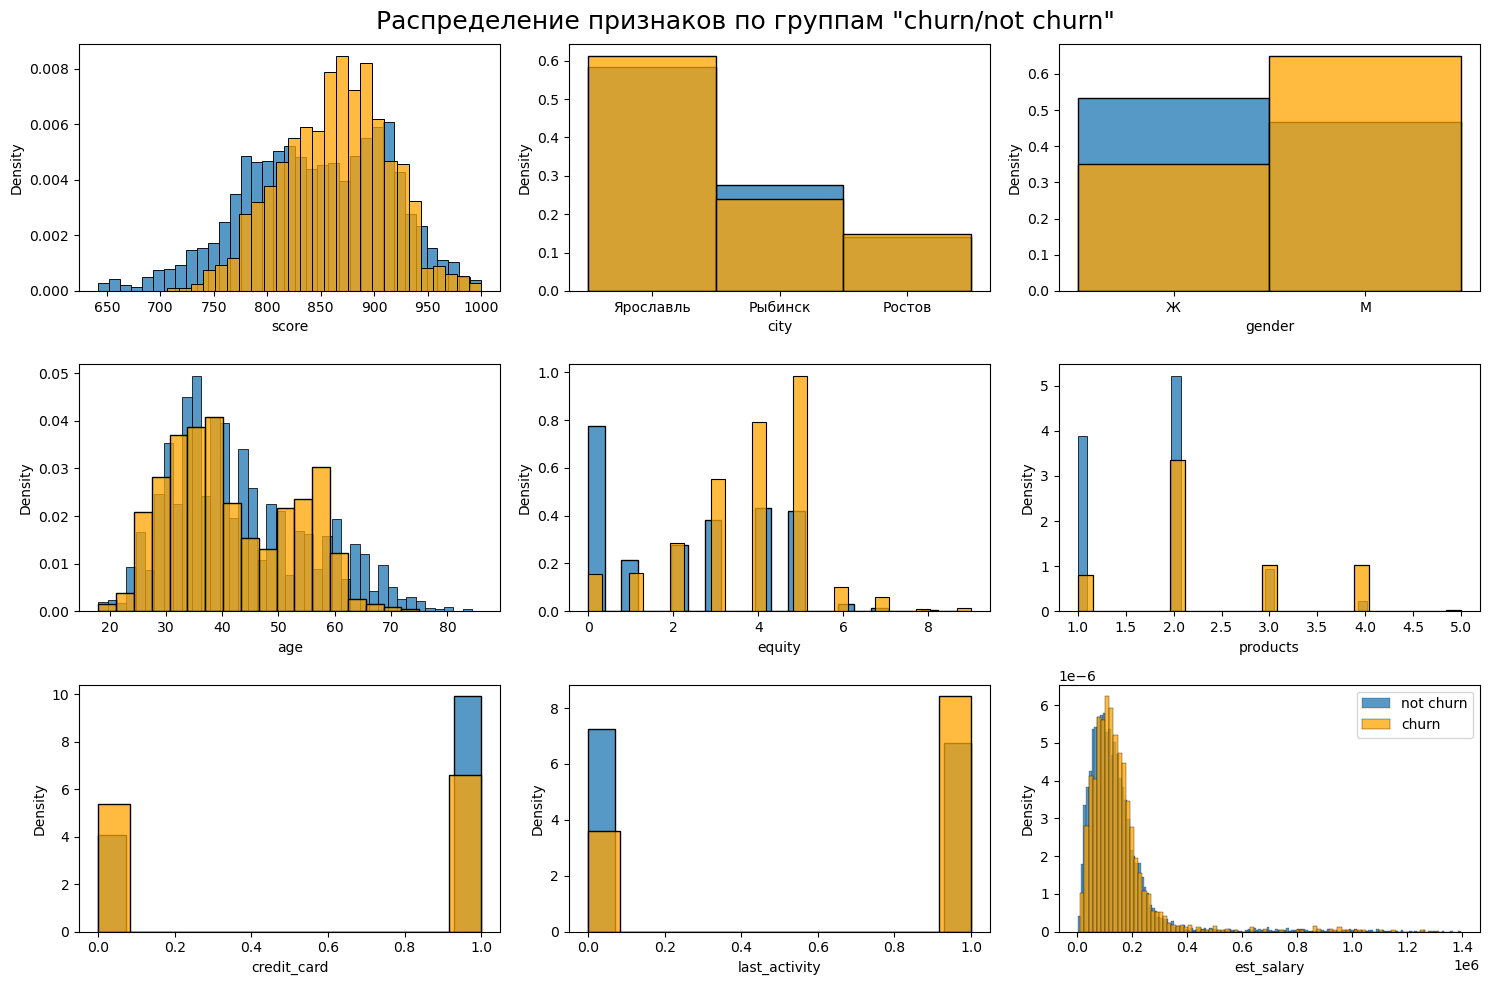

In [21]:
# смотрим распределение признаков по группам "churn/not churn" для определения возможных закономерностей
df_1 = df.drop(['balance', 'churn', 'rybinsk', 'rostov', 'jaroslavl', 'gender_codes'], axis=1)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

fig.suptitle('Распределение признаков по группам "churn/not churn"', fontsize=18)

for ax, feature in zip(axes, df_1.columns[1:16]):
    sns.histplot(df[df['churn'] == 0][feature], common_norm=False, stat="density", ax=ax)
    sns.histplot(df[df['churn'] == 1][feature], color="orange", common_norm=False, stat="density", ax=ax)

plt.legend(["not churn", "churn"])
plt.tight_layout()
plt.show()

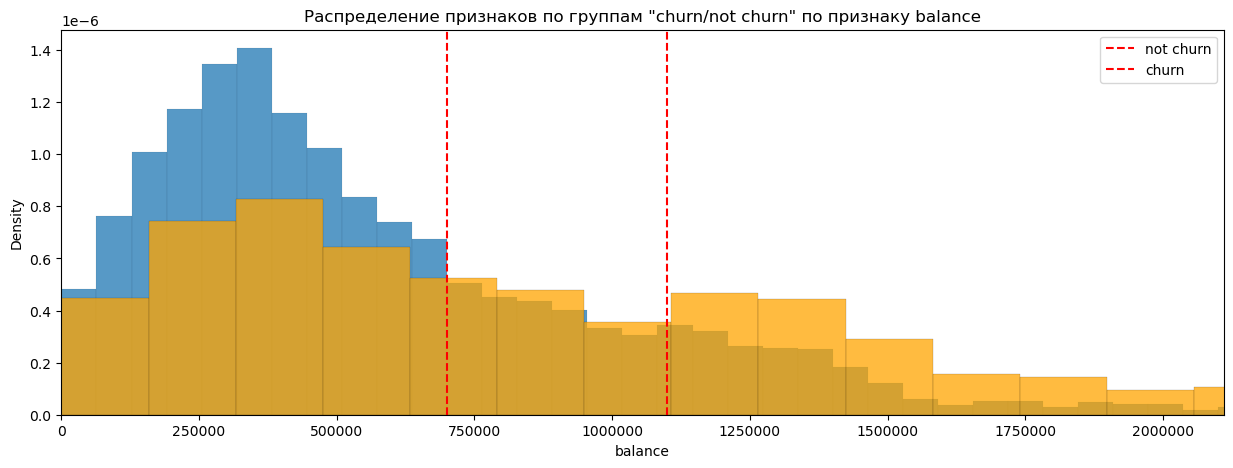

In [22]:
# смотрим распределение признаков по группам "churn/not churn" по признаку 'balance'

plt.figure(figsize=(15, 5))
sns.histplot(df[df['churn'] == 0]['balance'], common_norm=False, stat="density")
sns.histplot(df[df['churn'] == 1]['balance'], color="orange", common_norm=False, stat="density")

plt.title('Распределение признаков по группам "churn/not churn" по признаку balance')
plt.ticklabel_format(style='plain', axis='x') 
plt.xlim(0, df['balance'].quantile(0.95))
plt.axvline(x=1100000, color='r', linestyle='--', label='line_2')
plt.axvline(x=700000, color='r', linestyle='--', label='line_1')
plt.legend(["not churn", "churn"])
plt.show()

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Промежуточные выводы</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
  
По гистограммам распределения:
- score - более отточный сегмент (800-900)
- большая часть клиентов из города ярославль, при этом отточные распределены соответственно долям клиентов 
- Среди мужчин больше оттока
- возраст - возможно стоит рассмотреть сегменты 25-30, 50-60
- equity - в сегменте 3-5 отток выше
- product - сегмент 3-4
- credit card - сегмент без кредитных карт более отточна
- активные клиенты более отточны
- balance - 700K+. Однако в отрезке 700К-1100К эта разница не большая.

</div>

Далее смотрим динамику оттока по выделенным признакам, чтобы определить по каждому признаку отточные интервалы. Для этого строим barchart, который показывает долю оттока на каждом отрезке выделенного признака. 

К этому же графику добавляем горизонтальную линию среднего оттока по банку (18%) и выделяем интервалы, где отток значительно превышает средний отток по банку. 

Так же чтобы исключить выделение интервалов, с минимальным кол-вом клиентов, под каждым графиком доли оттока строим barchart по кол-ву клиентов в данном интервале.     

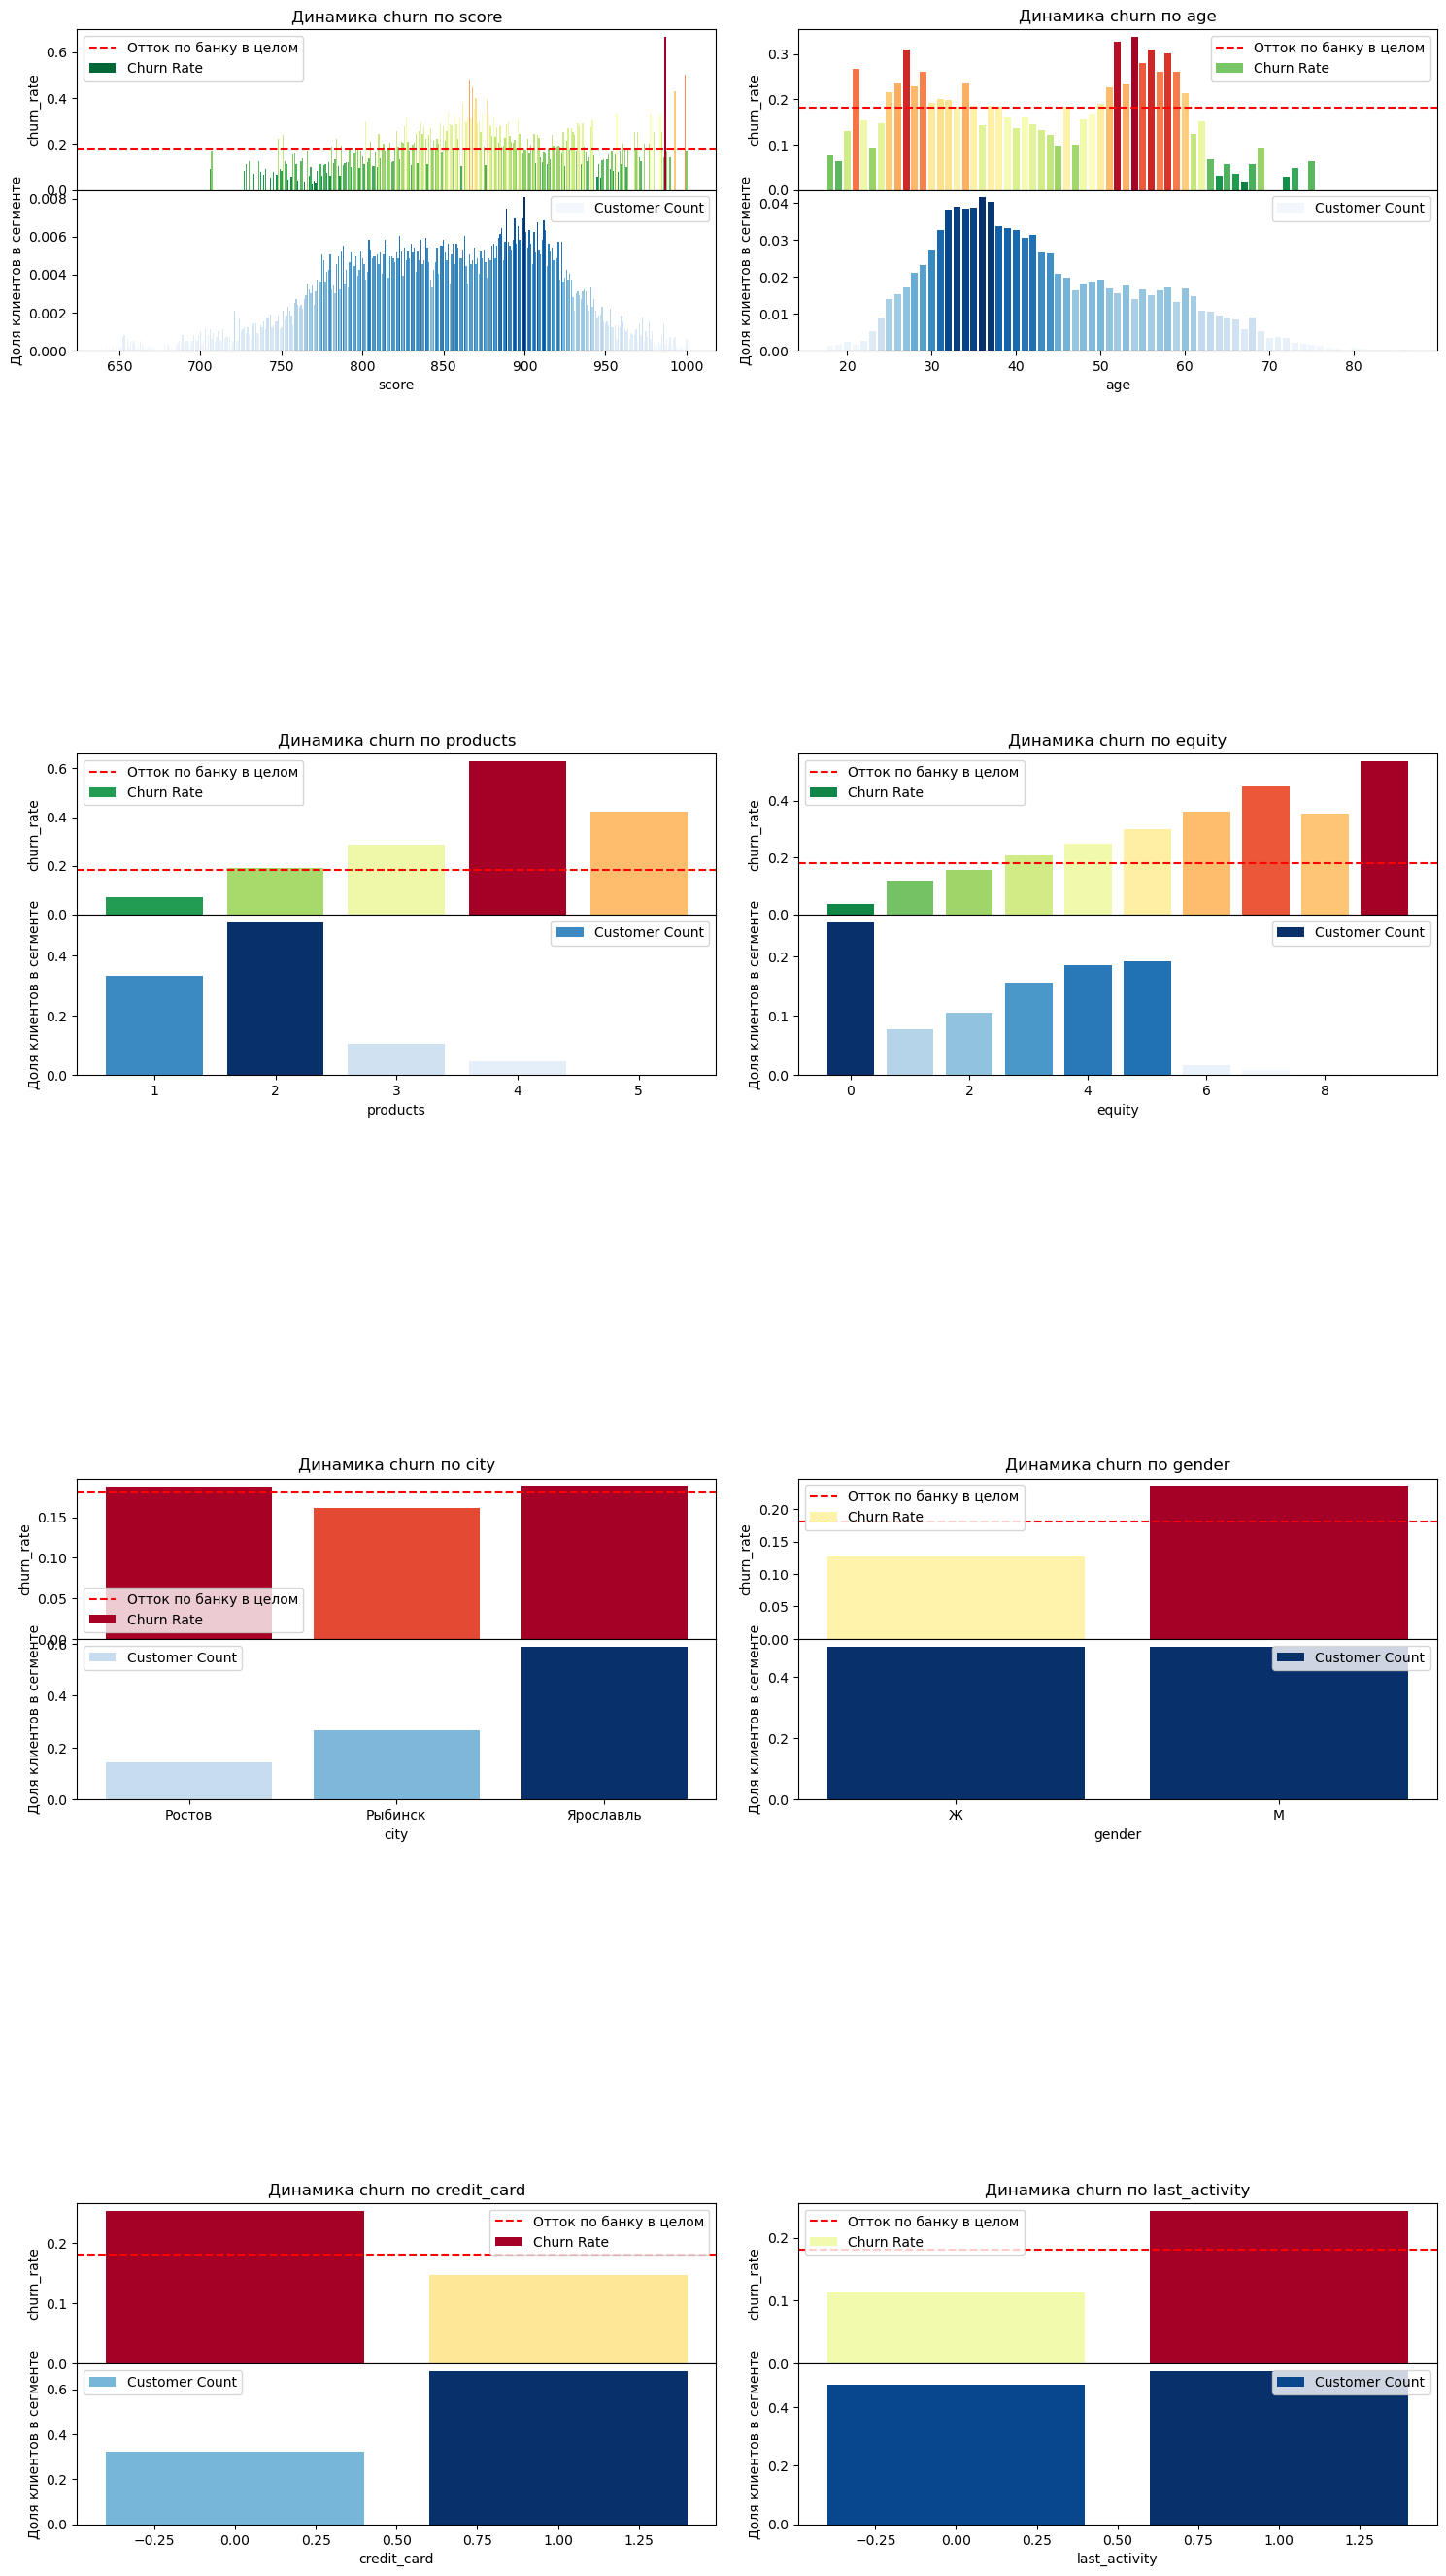

In [23]:
# для удобства чтения графиков подбираем colormap для графиков по доле оттока, и по доле клиентов в интервале. 

churn_rate_cmap = plt.get_cmap('RdYlGn_r')  # Colormap для churn rate столбцов
count_cmap = plt.get_cmap('Blues')        # Colormap для доли клиентов в сегменте


# по визуализациям выше выделила 8 признаков для анализа:

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30))
features = ['score', 'age', 'products', 'equity', 'city', 'gender', 'credit_card', 'last_activity']

for i, feature in enumerate(features):
    row = i // 2  
    col = i % 2   
    
    df_1 = df.groupby(feature, as_index=False).agg({'churn': ['sum', 'count', 'mean']})
    df_1.columns = [feature, 'churned', 'total', 'churn_rate']

    ax = axes[row, col]

    # строим сам barchart по churn rate
    churn_rates = df_1['churn_rate']
    churn_rate_colors = churn_rate_cmap(churn_rates / churn_rates.max())
    
    ax.bar(df_1[feature], df_1['churn_rate'], color=churn_rate_colors, label='Churn Rate')
    ax.axhline(y=df['churn'].mean(), color='r', linestyle='--', label='Отток по банку в целом')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('churn_rate')
    ax.set_title(f'Динамика churn по {feature}')
    ax.legend()

    
    # добавляем barchart по доле клиентов в сегментах
    ax_count = ax.inset_axes([0, -1, 1, 1])
    counts = (df_1['total'] / df_1['total'].sum())
    count_colors = count_cmap(counts / counts.max())  
        
    ax_count.bar(df_1[feature], counts, color=count_colors, label='Customer Count')
    ax_count.set_xlabel(feature)
    ax_count.set_ylabel('Доля клиентов в сегменте')
    ax_count.legend()
    
plt.tight_layout()
plt.show()

На основе проделанной работы можно выделить более отточные интервалы по признакам score, age. 

Признаки product, equity разобъем на более и менее отточные 2 сегмента. Например, по product мы видим что у большинства клиентов 1 или 2 продукта, и отток в этом сегменте меньше среднего оттока банка. А клиентов, у которых 3 и более продуктов мало, и их можно объединить в одну группу, так как общее "оттоковое" поведение у них схожее.

- score - high churn intervals:
850 - 900 *далее в высокоотточных интервалах по score очень малая доля клиентов, поэтому пока не будем их выделять в отдельные группы*

- age - high churn intervals: 
25 - 34, 51 - 60

- equity - high churn interval: 3+

- products - high churn interval: 4+

- city - нет ярковыраженных лидеров по оттоку

### Построить матрицу корреляции

In [24]:
# Расчёт матрицы корреляций

cm = df.corr()

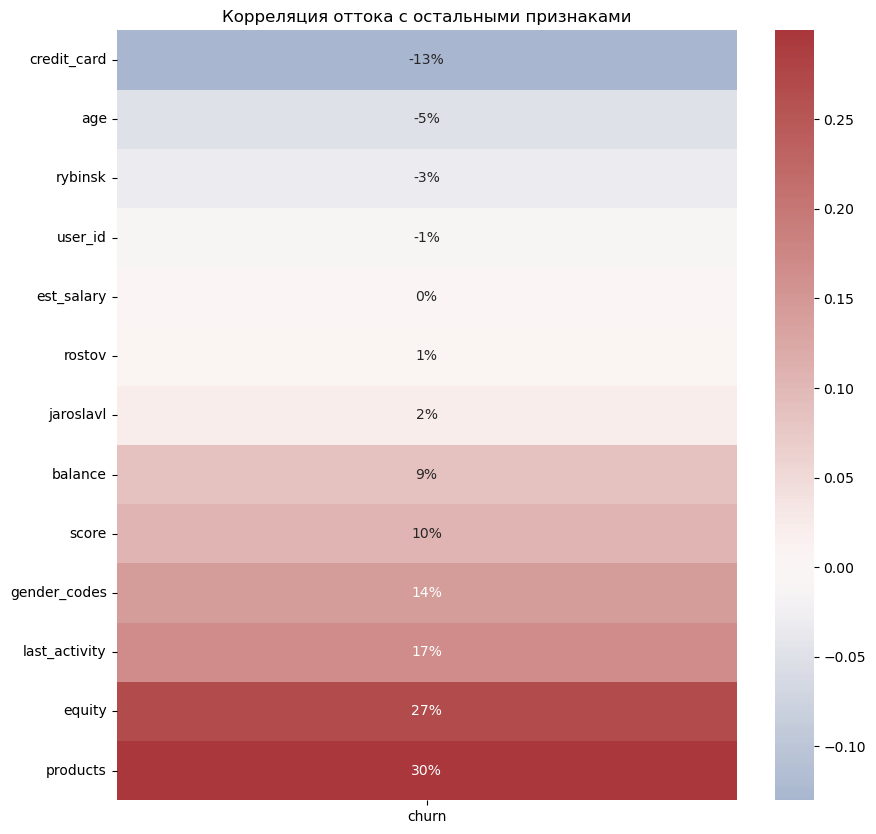

In [25]:
# хитмап матрицы корреляции для удобства интерпретации

plt.figure(figsize=(10,10))
sns.heatmap(
    cm.loc[:, ['churn']].drop('churn').sort_values(by='churn'), annot=True, fmt='.0%', center=0, cmap='vlag')
plt.title("Корреляция оттока с остальными признаками")
plt.show()

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Промежуточные выводы</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 

Визуализация корреляции дает нам следующую информацию:

* product, equity - показывает наибольшую прямую корреляцию, чем больше продуктов/собственности, тем более клиент склонен к оттоку
* last_activity, gender_codes - поля с бинарными значениями (где 1 - был активен/мужчина), показывают что клиенты, активные за последние 30 дней и мужчины более склонны к оттоку
* credit_card - обратная корреляция, где со значением 0 увеличивается отток, означает что клиенты без кредитных карт более склонны к оттоку.
        
Из графика динамики churn rate по **est_salary & city** и по хитмапу корреляции видно, что данные показатели абсолютно не коррелируются с оттоком, и в них нет явных более отточных интервалов, соответственно далее мы не будем анализировать показатели est_salary & city. 

По признакам **age, score, balance, equity, product** создадим дополнительные столбцы, где данные будут разбиты на ранее выделенные более/менее отточные интервалы

### Провести категоризацию по признакам age, score, equity, balance, products

In [26]:
# создадим функцию age_group для распределения клиентов по возрастным группам:

def age_group(age):
    if 25 <= age < 35:
        return '25-34'
    if  35 <= age < 51:
        return '35-50'
    if  51 <= age < 61:
        return '51-60'
    if age < 25:
        return 'under 25'
    if age >= 61:
        return '61+'   

def score_group(score):
    if 642 <= score < 850:
        return '642-850'
    if  850 <= score < 900:
        return '850-900'
    if score >= 900:
        return '900+'   

def balance_group(balance):
    if balance < 700000:
        return 'under 700K'
    if 700000 <= balance < 1100000:
        return '700K - 1100K'
    if balance >= 1100000:
        return '1100K+'   
    
def equity_group(equity):
    if equity < 3:
        return 'less than 3'
    if equity >= 3:
        return '3+'  
    
    
def product_group(products):
    if products < 4:
        return 'less than 4'
    if products >= 4:
        return '4+'  
    
# применим функцию age_group и добавим новый столбец

df['age_group'] = df['age'].apply (age_group)
df['score_group'] = df['score'].apply (score_group)
df['balance_group'] = df['balance'].apply (balance_group)
df['equity_group'] = df['equity'].apply (equity_group)
df['product_group'] = df['products'].apply (product_group)

df.head()

user_id  score       city gender   age  equity     balance  products  \
8913   229145  698.0  Ярославль      Ж  37.0       0         NaN         1   
1234   229136  883.0    Рыбинск      Ж  38.0       3   342099.90         2   
6059   229130  828.0  Ярославль      Ж  44.0       2   168323.87         2   
5764   229058  875.0  Ярославль      М  54.0       4  3680351.98         3   
2373   229054  883.0  Ярославль      М  27.0       0         NaN         1   

      credit_card  last_activity  ...  churn  gender_codes  rostov  rybinsk  \
8913            1              1  ...      0             0       0        0   
1234            1              0  ...      0             0       0        1   
6059            1              1  ...      0             0       0        0   
5764            0              1  ...      1             1       0        0   
2373            1              1  ...      0             1       0        0   

      jaroslavl  age_group score_group balance_group equity_group  \
8913          1      35-50     642-850          None  less than 3   
1234          0      35-50     850-900    under 700K           3+   
6059          1      35-50     642-850    under 700K  less than 3   
5764          1      51-60     850-900        1100K+           3+   
2373          1      25-34     850-900          None  less than 3   

     product_group  
8913   less than 4  
1234   less than 4  
6059   less than 4  
5764   less than 4  
2373   less than 4  

[5 rows x 21 columns]

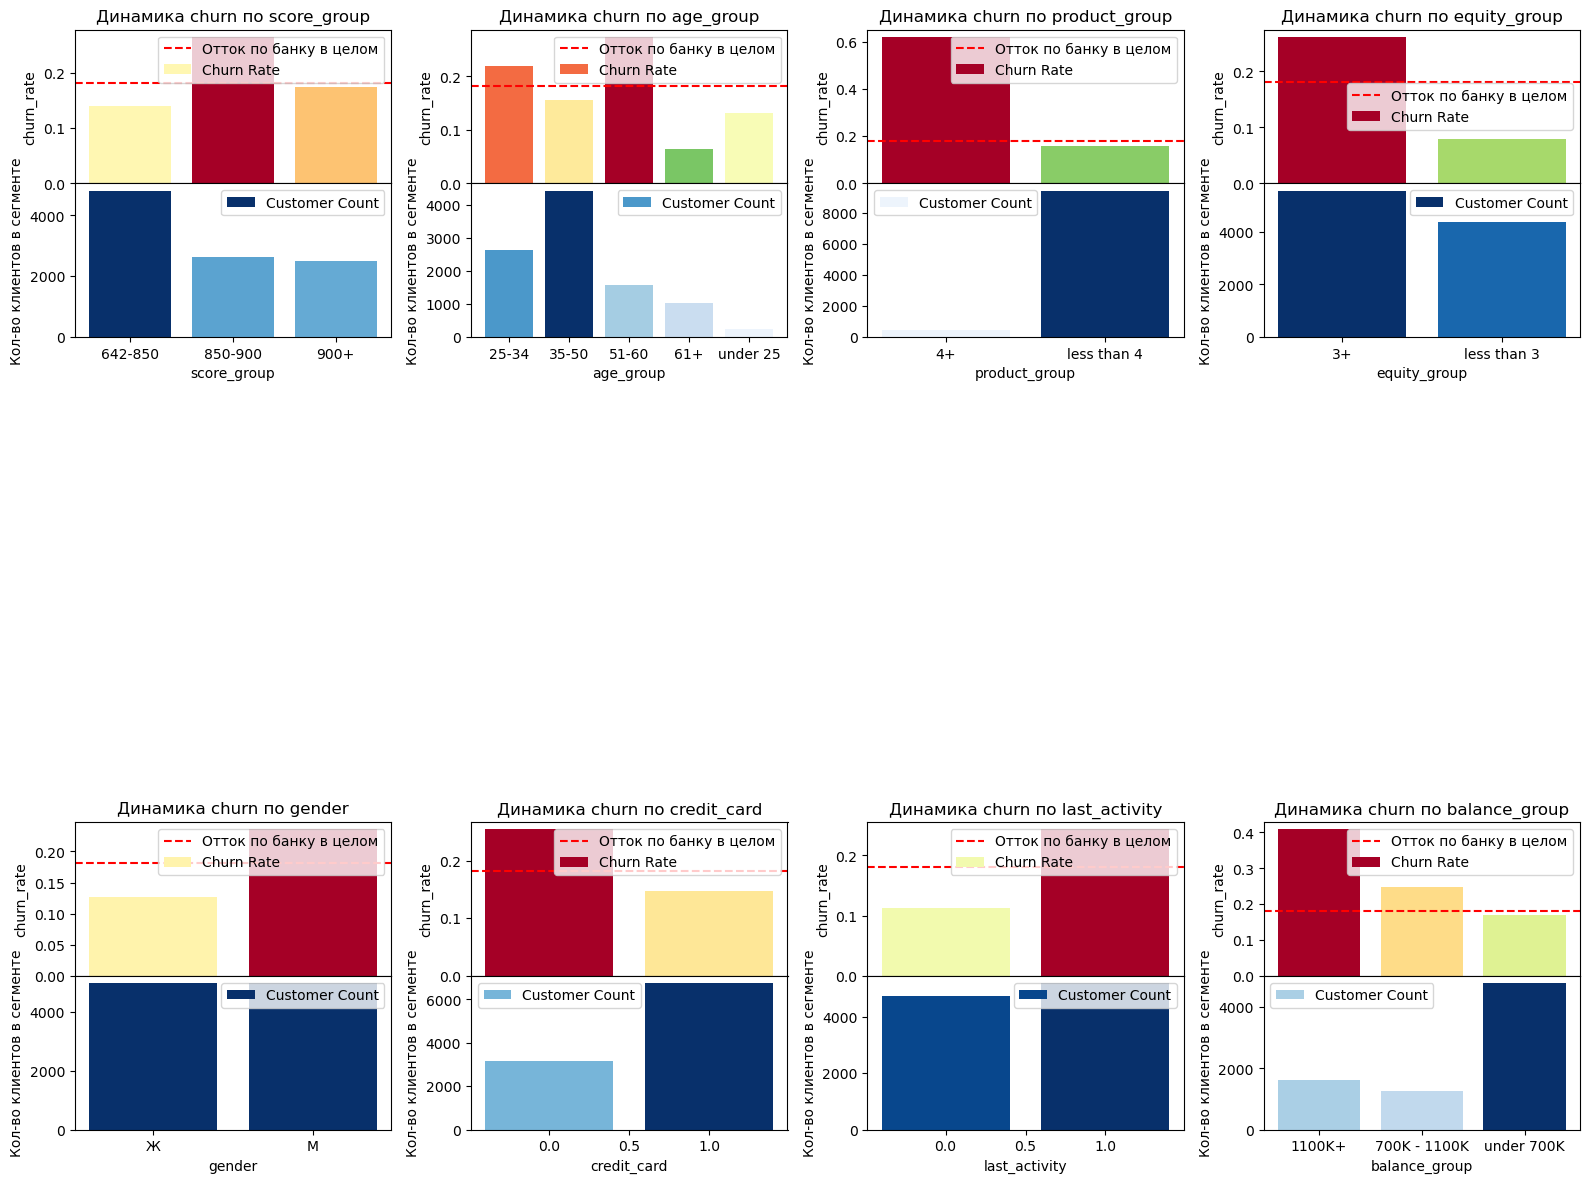

In [27]:
# Далее смотрим динамику оттока как ранее, но уже по новым столбцам:

churn_rate_cmap = plt.get_cmap('RdYlGn_r')  
count_cmap = plt.get_cmap('Blues')        

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 16))
features = ['score_group', 'age_group', 'product_group', 'equity_group', 'gender', 'credit_card', 'last_activity', 'balance_group']

for i, feature in enumerate(features):
    row = i // 4  
    col = i % 4
    
    df_1 = df.groupby(feature, as_index=False).agg({'churn': ['sum', 'count', 'mean']})
    df_1.columns = [feature, 'churned', 'total', 'churn_rate']

    ax = axes[row, col]
    
    churn_rates = df_1['churn_rate']
    churn_rate_colors = churn_rate_cmap(churn_rates / churn_rates.max())
    
    ax.bar(df_1[feature], df_1['churn_rate'], color=churn_rate_colors, label='Churn Rate')
    ax.axhline(y=df['churn'].mean(), color='r', linestyle='--', label='Отток по банку в целом')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('churn_rate')
    ax.set_title(f'Динамика churn по {feature}')
    ax.legend()

    
    
    ax_count = ax.inset_axes([0, -1, 1, 1])
    counts = df_1['total']
    count_colors = count_cmap(counts / counts.max())  
        
    ax_count.bar(df_1[feature], counts, color=count_colors, label='Customer Count')
    ax_count.set_xlabel(feature)
    ax_count.set_ylabel('Кол-во клиентов в сегменте')
    ax_count.legend()
    
plt.tight_layout()
plt.show()

### Составить портрет клиента в каждом из групп

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Промежуточные выводы</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 

**Портрет отточного клиента**
- Кредитный рейтинг (score) в интервале 850-900
- Возраст в интервалах 25-34, 51-60
- Пользуется 4 и более продуктами банка
- Имеет 3 и более собственности (equity)
- Мужского пола
- Не имеет кредитной карты
- Был активен за последний месяц
- Баланс больше 700К

**Портрет не отточного клиента**
- Кредитный рейтинг (score) в интервале 642-850, 901+
- Возраст в интервалах 18-24, 35-50, 61+
- Пользуется до 3-х продуктами банка
- Имеет менее 3 собственности (equity)
- Женского пола
- Имеет кредитную карту
- Не был активен за последний месяц
- Баланс меньше 700К

Тут необходимо учитывать, что мы выделили интервалы с высокой долей оттока, и выделили обобщающие признаки отточности по всем признакам. Но стоит отметить, что в не отточных интервалах тоже есть отточные клиенты, но в этих интервалах показатель оттока меньше среднего показателя оттока по банку (<18%)

## Формулировка и проверка гипотез 

<div class="alert alert-info">

    
alpha = 0.05
    
Для проверки гипотез применила метод scipy.stats.ttest_ind(), так как в обоих кейсах генеральные совокупности не зависят друг от друга.

 <b> Проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались </b>
    

H0: статистически значимых различий в средних доходах отточных и не отточных клиентов нет.    
H1: отличия в доходах среди отточных и не отточных клиентов есть.
    
   

In [28]:
# Готовим выборки и сохраняем в переменных sample_1, sample_2

sample_1 = df[df['churn'] == 0]['est_salary'].dropna().reset_index(drop=True)
sample_2 = df[df['churn'] == 1]['est_salary'].dropna().reset_index(drop=True)

# задаем уровень стат. значимости для теста
alpha = 0.05

results = st.ttest_ind(sample_1, sample_2)

print('Средний доход не отточных клиентов', round(sample_1.mean(), 2))
print('Средний доход отточных клиентов', round(sample_2.mean(), 2))
print()
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    

Средний доход не отточных клиентов 147633.91
Средний доход отточных клиентов 148359.56

p-значение: 0.8415765007169007
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-info"> 
 <b>Проверить гипотезу о том, что мужчины более склонны к оттоку </b>
    

H0: статистически значимых различий в среднем оттоке у мужчин и женщин нет.    
H1: отличия в уровне оттока среди мужчин и женщин есть.
    


In [29]:
# Готовим выборки и сохраняем в переменных sample_1, sample_2
sample_1_success = df[df['gender_codes'] == 0]['churn'].sum()  # сумма дает кол-во отточных
sample_1_attempts = df[df['gender_codes'] == 0]['churn'].count()  # кол-во дает общее кол-во вводных в выборке

sample_2_success = df[df['gender_codes'] == 1]['churn'].sum()  
sample_2_attempts = df[df['gender_codes'] == 1]['churn'].count()  


count = np.array([sample_1_success, sample_2_success])
nobs = np.array([sample_1_attempts, sample_2_attempts])

z_stat, p_value = proportions_ztest(count, nobs, alternative='smaller') 

print('Отток среди женщин', round(sample_1.mean(), 2))
print('Отток среди мужчин', round(sample_2.mean(), 2))
print()
print('p-значение (prop_test):', p_value)

alpha = 0.05

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


Отток среди женщин 147633.91
Отток среди мужчин 148359.56

p-значение (prop_test): 3.1693485907287976e-45
Отвергаем нулевую гипотезу


<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Интерпретация результата:</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 


<b> Проверьте гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались </b>
    

H0: статистически значимых различий в средних доходах отточных и не отточных клиентов нет.    
H1: отличия в доходах среди отточных и не отточных клиентов есть.

Полученное p-value говорит о том, что хотя средний доход отточных и не отточных клиентов неодинаковый, <b>  с вероятности почти в 84% такое и большее различие можно получить случайно. </b> Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между доходами групп. Соответственно доход, как один из признаков не оказывает влияния на показатель оттока в банке. 
    
 <b> Мужчины более склонны к оттоку </b>
    

H0: статистически значимых различий в среднем оттоке у мужчин и женщин нет.    
H1: отличия в уровне оттока среди мужчин и женщин есть.
    
    
Полученное p-value говорит о том, что вероятность случайно получить такое различие в показателе оттока мужчин и женщин ничтожно мала. Соответственно, отвергаем нулевую гипотезу о равных показателях оттока у групп, и исходя из показателей оттока в группах, убеждаемся что мужчины действительно более склонны к оттоку


## Сегментация

### Выделить сегменты в отдельные датафреймы, оценив объем сегмента и churn rate внутри сегмента

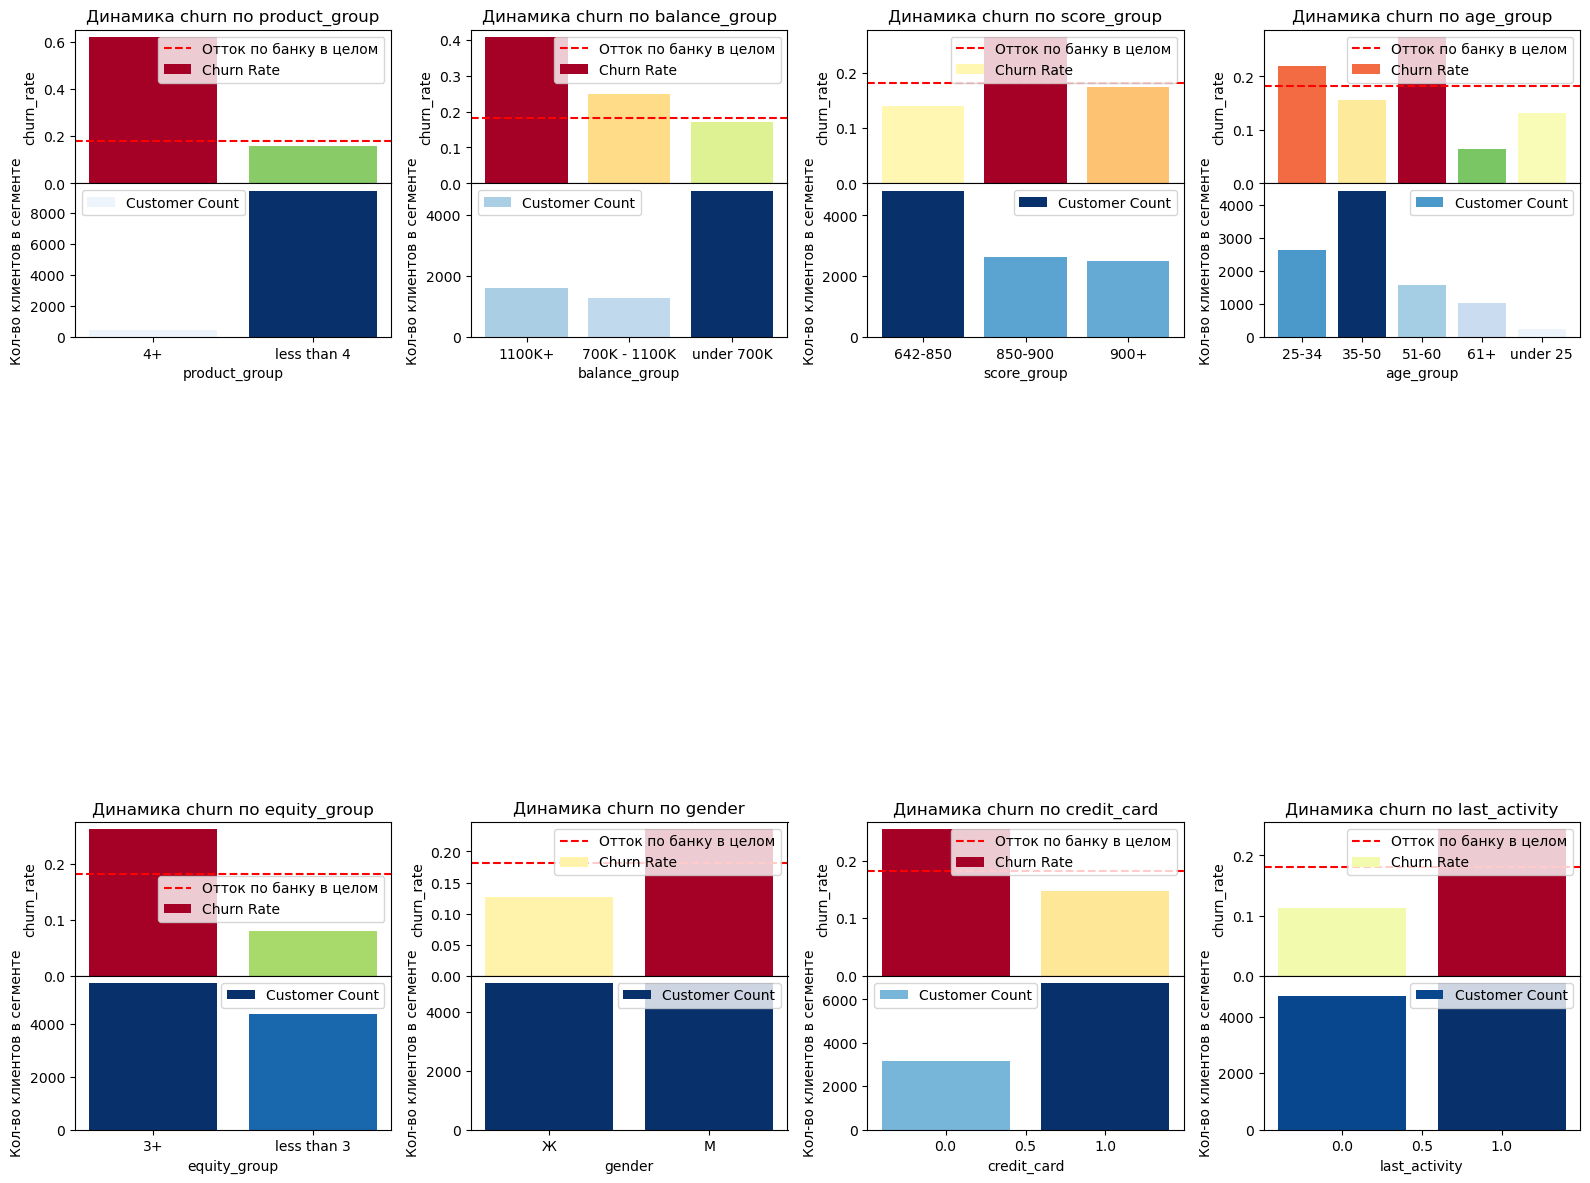

In [30]:
# Далее смотрим динамику оттока как ранее, но уже по новым столбцам:

churn_rate_cmap = plt.get_cmap('RdYlGn_r')  
count_cmap = plt.get_cmap('Blues')        

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 16))
features = ['product_group', 'balance_group', 'score_group', 'age_group', 'equity_group', 'gender', 'credit_card', 'last_activity']

for i, feature in enumerate(features):
    row = i // 4  
    col = i % 4
    
    df_1 = df.groupby(feature, as_index=False).agg({'churn': ['sum', 'count', 'mean']})
    df_1.columns = [feature, 'churned', 'total', 'churn_rate']

    ax = axes[row, col]
    
    churn_rates = df_1['churn_rate']
    churn_rate_colors = churn_rate_cmap(churn_rates / churn_rates.max())
    
    ax.bar(df_1[feature], df_1['churn_rate'], color=churn_rate_colors, label='Churn Rate')
    ax.axhline(y=df['churn'].mean(), color='r', linestyle='--', label='Отток по банку в целом')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('churn_rate')
    ax.set_title(f'Динамика churn по {feature}')
    ax.legend()

    
    
    ax_count = ax.inset_axes([0, -1, 1, 1])
    counts = df_1['total']
    count_colors = count_cmap(counts / counts.max())  
        
    ax_count.bar(df_1[feature], counts, color=count_colors, label='Customer Count')
    ax_count.set_xlabel(feature)
    ax_count.set_ylabel('Кол-во клиентов в сегменте')
    ax_count.legend()
    
plt.tight_layout()
plt.show()

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Промежуточные выводы</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 

На визуализации выше можно увидеть объемы сегментов по разным признакам, и churn rate внутри этих сегментов, так же у нас есть горизонтальная линия среднего оттока по банку, чтобы визуально быстро определить западающие сегменты. 
        
**Какие факторы сильнее влияют на отток?**
        
Смотрим где churn rate сильнее выбивается от среднего, и получаем:
- product_group
- balance_group
- остальные примерно одинаково

Так как отточные интервалы по признакам `balance_group` & `product_group` уже имеют отток почти 2+ раза выше среднего оттока по банку, мы сразу же выделим данных клиентов в отдельные сегменты.
        
Остальные признаки будем ранжировать по порядку убывания кол-ва клиентов в отточных сегментах далее в рамках работы.

In [31]:
# смотрим описание сегмента по balance_group: общее кол-во клиентов, кол-во оттока, доля оттока

temp = df.groupby(['balance_group', ], as_index=False).agg({'churn': ['count', 'sum', 'mean']})
temp.columns = ['balance_group', 'total', 'churned', 'churn_rate']
temp['churn_rate'] = round(temp['churn_rate'], 2)
temp.sort_values(by='churn_rate', ascending=False)

balance_group  total  churned  churn_rate
0        1100K+   1608      657        0.41
1  700K - 1100K   1276      317        0.25
2    under 700K   4783      812        0.17

In [32]:
# выделяем сегмент в отдельный датафрейм:

seg_1 = df.query('balance_group == "1100K+"')
seg_from_df_1 = df.query('balance_group == "1100K+"')

# оставшихся клиентов записываем в новый датафрейм, так как далее будем по частям забирать отточные сегменты из остатка
remaining_rows = df.query('balance_group != "1100K+"')
remaining_rows.shape

(8318, 21)

Тут и далее я буду выделять нужный нам сегмент из основного датафрейма (df) и остаточного датафрейма (remaining_rows), и буду сохранять их в новых датафреймах под названием seg_from_df_n и seg_n.

Это необходимо для учета уникальных отточных клиентов, и для оценки всего сегмента для банка, так как в рамках проведения маркетинговых работ отдельные клиенты будут заходить в разные сегменты одновременно. А нам в рамках работы важно захватить как можно большее кол-во уникальных отточных клиентов.

In [33]:
# смотрим описание сегмента по product_group: общее кол-во клиентов, кол-во оттока, доля оттока

temp = remaining_rows.groupby(['product_group', ], as_index=False).agg({'churn': ['count', 'sum', 'mean']})
temp.columns = ['product_group', 'total', 'churned', 'churn_rate']
temp.sort_values(by='churn_rate', ascending=False)

product_group  total  churned  churn_rate
0            4+    263      116    0.441065
1   less than 4   8055     1025    0.127250

In [34]:
# выделяем сегмент в отдельный датафрейм, и обновляем датафрейм с оставшимися клиентами

seg_2 = remaining_rows.query('product_group == "4+"')
seg_from_df_2 = df.query('product_group == "4+"')

remaining_rows = remaining_rows.query('product_group != "4+"')
remaining_rows.shape

(8055, 21)

In [35]:
# Создаем словарь с описанием значении полей

custom_labels = {
    'equity_group': {
        'less than 3': 'Меньше 3 объектов собст',
        '3+': 'Больше 3 объектов собст'
    },
    'last_activity': {
        0: 'Не был активен за посл месяц',
        1: 'Был активен за посл месяц'
    },
    'gender': {
        'М': 'Мужчина',
        'Ж': 'Женщина'
    },
    'credit_card': {
        0: 'Нет кредитной карты',
        1: 'Есть кредитная карта'
    }
}

churn_rates = df.groupby(
    ['equity_group', 'last_activity', 'gender', 'credit_card'],
    as_index=False
).agg({'churn': ['sum', 'count', 'mean']})

churn_rates.columns = ['equity_group', 'last_activity', 'gender', 'credit_card',
                       'churn_count', 'segment_count', 'churn']


# Меняем значения полей на описания этих значении из словаря

for column in custom_labels:
    churn_rates[column] = churn_rates[column].map(custom_labels[column])

churn_rates.head(3)

equity_group                 last_activity   gender  \
0  Больше 3 объектов собст  Не был активен за посл месяц  Женщина   
1  Больше 3 объектов собст  Не был активен за посл месяц  Женщина   
2  Больше 3 объектов собст  Не был активен за посл месяц  Мужчина   

            credit_card  churn_count  segment_count     churn  
0   Нет кредитной карты           32            549  0.058288  
1  Есть кредитная карта           51            783  0.065134  
2   Нет кредитной карты          130            386  0.336788

In [36]:
# строим treemap
fig = px.treemap(
    churn_rates,
    path=[
        'equity_group', 'last_activity', 'gender', 'credit_card',
    ],
    values='churn',
    color='churn',
    hover_data=[
        'equity_group', 'last_activity', 'gender', 'credit_card', 'churn_count', 'segment_count'],  
    color_continuous_scale='Bluered',
    title='treemap с долей оттока в сегментах из всей базы клиентов банка'
)

for i, column in enumerate(custom_labels):
    tickvals = list(range(len(custom_labels[column])))
    ticktext = list(custom_labels[column].values())
    fig.update_xaxes(categoryorder='total descending', title_text=column.capitalize(), tickvals=tickvals, ticktext=ticktext, row=i + 1, col=1)

fig.show()

In [37]:
# Создаем словарь с описанием значении полей

custom_labels = {
    'equity_group': {
        'less than 3': 'Меньше 3 объектов собст',
        '3+': 'Больше 3 объектов собст'
    },
    'last_activity': {
        0: 'Не был активен за посл месяц',
        1: 'Был активен за посл месяц'
    },
    'gender': {
        'М': 'Мужчина',
        'Ж': 'Женщина'
    },
    'credit_card': {
        0: 'Нет кредитной карты',
        1: 'Есть кредитная карта'
    }
}

churn_rates = remaining_rows.groupby(
    ['equity_group', 'last_activity', 'gender', 'credit_card'],
    as_index=False
).agg({'churn': ['sum', 'count', 'mean']})

churn_rates.columns = ['equity_group', 'last_activity', 'gender', 'credit_card',
                       'churn_count', 'segment_count', 'churn']


# Меняем значения полей на описания этих значении из словаря

for column in custom_labels:
    churn_rates[column] = churn_rates[column].map(custom_labels[column])

# строим treemap
fig = px.treemap(
    churn_rates,
    path=[
        'equity_group', 'last_activity', 'gender', 'credit_card',
    ],
    values='churn',
    color='churn',
    hover_data=[
        'equity_group', 'last_activity', 'gender', 'credit_card', 'churn_count', 'segment_count'],  
    color_continuous_scale='Bluered',
    title='treemap с долей оттока в сегментах из остатка'
)

for i, column in enumerate(custom_labels):
    tickvals = list(range(len(custom_labels[column])))
    ticktext = list(custom_labels[column].values())
    fig.update_xaxes(categoryorder='total descending', title_text=column.capitalize(), tickvals=tickvals, ticktext=ticktext, row=i + 1, col=1)

fig.show()

In [38]:
# выделяем самый отточный сегмент из treemap в отдельный датафрейм, и обновляем датафрейм с оставшимися клиентами

seg_3 = remaining_rows.query('equity_group == "3+" and last_activity == 1 and gender == "М" and credit_card == 0')
seg_from_df_3 = df.query('equity_group == "3+" and last_activity == 1 and gender == "М" and credit_card == 0')

remaining_rows = remaining_rows.query(
    'equity_group != "3+" | last_activity != 1 | gender != "М" | credit_card != 0')
remaining_rows.shape

(7811, 21)

In [39]:
# Создаем словарь с описанием значении полей

custom_labels = {
    'equity_group': {
        'less than 3': 'Меньше 3 объектов собст',
        '3+': 'Больше 3 объектов собст'
    },
    'last_activity': {
        0: 'Не был активен за посл месяц',
        1: 'Был активен за посл месяц'
    },
    'score_group': {
        '642-850': 'кредитный скор 642-850',
        '850-900': 'кредитный скор 850-900',
        '900+': 'кредитный скор900+'
    }
}

churn_rates = df.groupby(
    ['equity_group', 'last_activity', 'score_group'],
    as_index=False
).agg({'churn': ['sum', 'count', 'mean']})

churn_rates.columns = ['equity_group', 'last_activity', 'score_group',
                       'churn_count', 'segment_count', 'churn']


# Меняем значения полей на описания этих значении из словаря

for column in custom_labels:
    churn_rates[column] = churn_rates[column].map(custom_labels[column])

# строим treemap
filtered_churn_rates = churn_rates[churn_rates['churn'] > 0]

fig = px.treemap(
    filtered_churn_rates,
    path=[
        'equity_group', 'last_activity', 'score_group',
    ],
    values='churn',
    color='churn',
    hover_data=[
        'equity_group', 'last_activity', 'score_group', 'churn_count', 'segment_count'], 
    color_continuous_scale='Bluered',
    title='treemap с долей оттока в сегментах'
)

for i, column in enumerate(custom_labels):
    tickvals = list(range(len(custom_labels[column])))
    ticktext = list(custom_labels[column].values())
    fig.update_xaxes(categoryorder='total descending', title_text=column.capitalize(), tickvals=tickvals, ticktext=ticktext, row=i + 1, col=1)

fig.show()

In [40]:
# Создаем словарь с описанием значении полей

custom_labels = {
    'equity_group': {
        'less than 3': 'Меньше 3 объектов собст',
        '3+': 'Больше 3 объектов собст'
    },
    'last_activity': {
        0: 'Не был активен за посл месяц',
        1: 'Был активен за посл месяц'
    },
    'score_group': {
        '642-850': 'кредитный скор 642-850',
        '850-900': 'кредитный скор 850-900',
        '900+': 'кредитный скор900+'
    }
}

churn_rates = remaining_rows.groupby(
    ['equity_group', 'last_activity', 'score_group'],
    as_index=False
).agg({'churn': ['sum', 'count', 'mean']})

churn_rates.columns = ['equity_group', 'last_activity', 'score_group',
                       'churn_count', 'segment_count', 'churn']


# Меняем значения полей на описания этих значении из словаря

for column in custom_labels:
    churn_rates[column] = churn_rates[column].map(custom_labels[column])

# строим treemap
filtered_churn_rates = churn_rates[churn_rates['churn'] > 0]

fig = px.treemap(
    filtered_churn_rates,
    path=[
        'equity_group', 'last_activity', 'score_group',
    ],
    values='churn',
    color='churn',
    hover_data=[
        'equity_group', 'last_activity', 'score_group', 'churn_count', 'segment_count'], 
    color_continuous_scale='Bluered',
    title='treemap с долей оттока в сегментах'
)

for i, column in enumerate(custom_labels):
    tickvals = list(range(len(custom_labels[column])))
    ticktext = list(custom_labels[column].values())
    fig.update_xaxes(categoryorder='total descending', title_text=column.capitalize(), tickvals=tickvals, ticktext=ticktext, row=i + 1, col=1)

fig.show()

In [41]:
# выделяем самый отточный сегмент из treemap в отдельный датафрейм, и обновляем датафрейм с оставшимися клиентами

seg_4 = remaining_rows.query('equity_group == "3+" and last_activity == 1 and score_group == "850-900"')
seg_from_df_4 = df.query('equity_group == "3+" and last_activity == 1 and score_group == "850-900"')

remaining_rows = remaining_rows.query(
    '~(equity_group == "3+" and last_activity == 1 and score_group == "850-900")')
remaining_rows.shape


(7336, 21)

Мы выделили 4 сегмента отточных клиентов, при этом в эти сегменты попали 2590 клиентов, из них 1108 уникальных клиентов уходящих в отток. Это 26% клиентской базы банка, и 61,7% всех отточных клиентов. 

В оставшейся части датафрейма 7336 уникальных клиентов, из них 687 отточных клиентов (churn rate ~9%). 

Далее построим графики по динамике оттока по всем признакам, по базе не вошедших в выделенные сегменты клиентов:

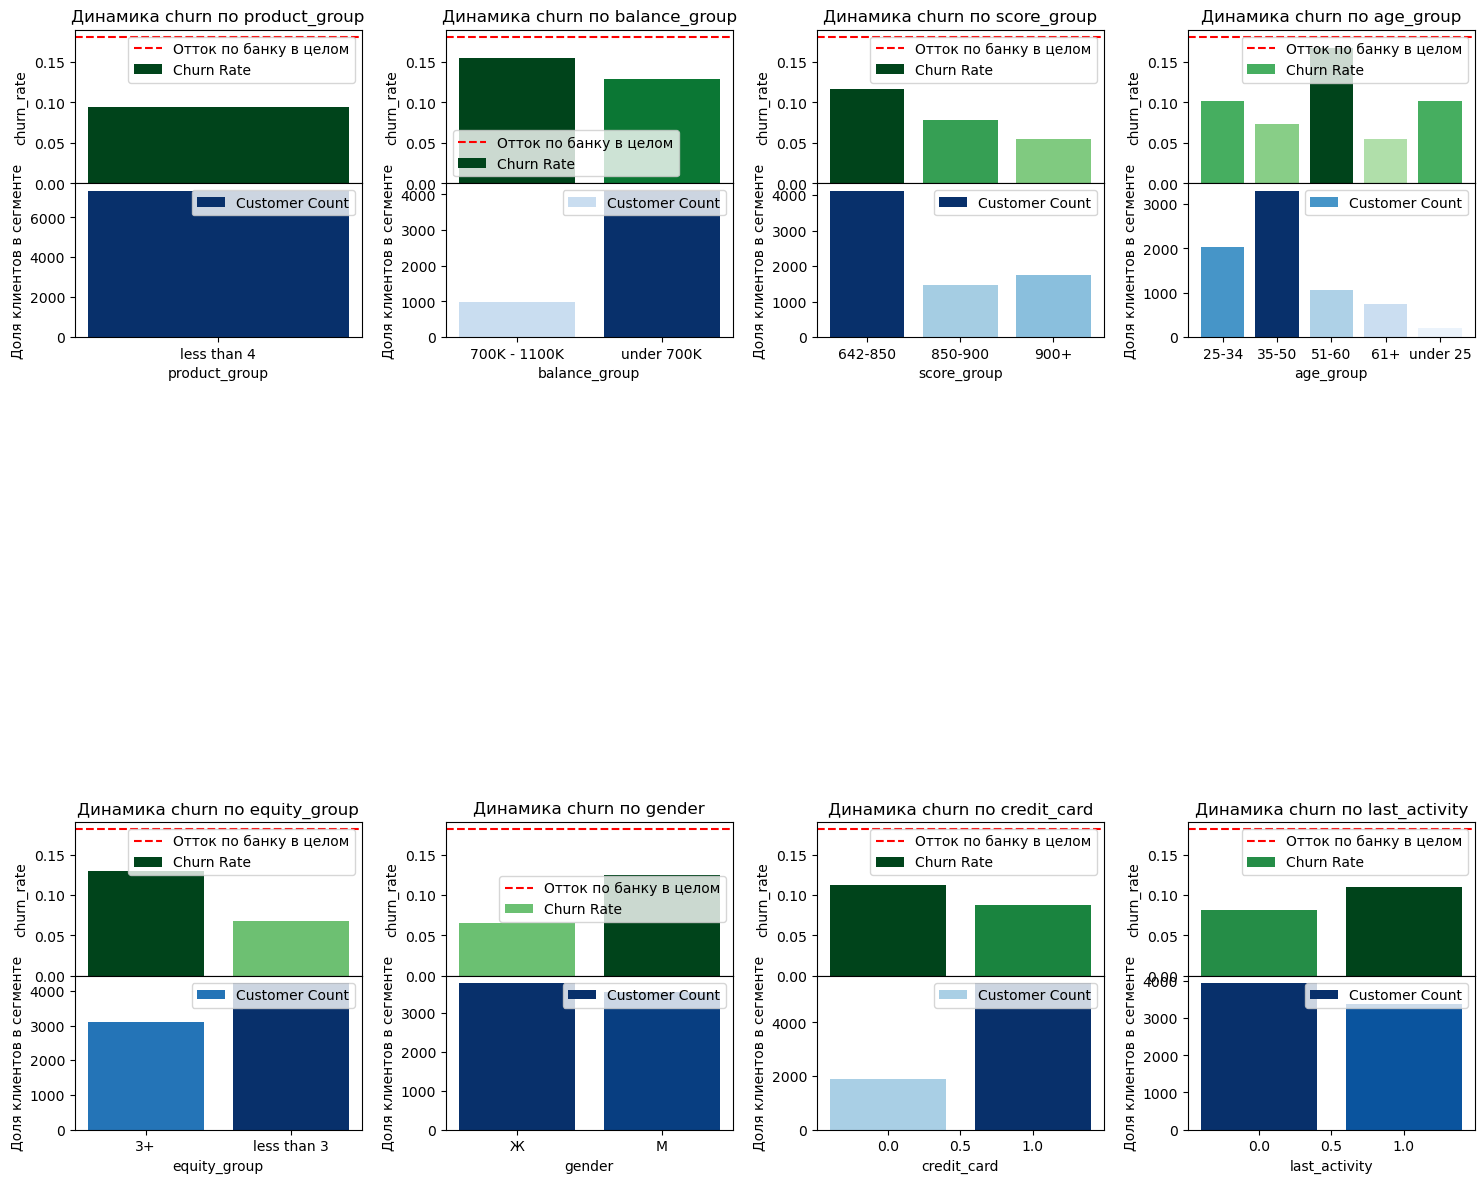

In [42]:

churn_rate_cmap = plt.get_cmap('Greens')  
count_cmap = plt.get_cmap('Blues')        

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 16))
features = ['product_group', 'balance_group', 'score_group', 'age_group', 'equity_group', 'gender', 'credit_card', 'last_activity', ]

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4 
    
    df_1 = remaining_rows.groupby(
        feature, as_index=False).agg({'churn': ['sum', 'count', 'mean']})
    df_1.columns = [feature, 'churned', 'total', 'churn_rate']

    ax = axes[row, col]
    
    churn_rates = df_1['churn_rate']
    churn_rate_colors = churn_rate_cmap(churn_rates / churn_rates.max())
    
    ax.bar(df_1[feature], df_1['churn_rate'], color=churn_rate_colors, label='Churn Rate')
    ax.axhline(y=df['churn'].mean(), color='r', linestyle='--', label='Отток по банку в целом')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('churn_rate')
    ax.set_title(f'Динамика churn по {feature}')
    ax.legend()

    
    
    ax_count = ax.inset_axes([0, -1, 1, 1])
    counts = df_1['total']
    count_colors = count_cmap(counts / counts.max())  # Map counts to count colormap
        
    ax_count.bar(df_1[feature], counts, color=count_colors, label='Customer Count')
    ax_count.set_xlabel(feature)
    ax_count.set_ylabel('Доля клиентов в сегменте')
    ax_count.legend()
    
plt.tight_layout()
plt.show()

По графикам выше видно, что по всем имеющимся признакам не осталось интервалов, превышающих средний отток банка. И если правильно подобрать метод работы с выделенными ранее отточными сегментами, удастся снизить уровень оттока в банке от текущих 18%

### Приоритизация сегментов

In [43]:
# отобразим статистику по кол-ву уникальных клиентов

concatenated_rows = pd.concat([seg_1, seg_2, seg_3, seg_4],  keys=['seg_1', 'seg_2', 'seg_3', 'seg_4']).reset_index()
temp = concatenated_rows.groupby(['level_0', ], as_index=False).agg({'churn': ['count', 'sum', 'mean']})
temp.columns = ['segment_name', 'clients_count', 'churned', 'churn_rate']
sum_row = temp[['clients_count', 'churned']].sum()
sum_row['churn_rate'] = sum_row['churned'] / sum_row['clients_count']

temp.loc['Sum'] = ['total', sum_row['clients_count'], sum_row['churned'], sum_row['churn_rate']]
temp

segment_name  clients_count  churned  churn_rate
0          seg_1         1608.0    657.0    0.408582
1          seg_2          263.0    116.0    0.441065
2          seg_3          244.0    119.0    0.487705
3          seg_4          475.0    216.0    0.454737
Sum        total         2590.0   1108.0    0.427799

Так как отдель маркетинга будет проводить работы со всеми сегментами одновременно, некоторые клиенты будут попадать
в несколько сегментов. И для отдела важно знать объемы всего сегмента, включая тех, кто сидит в нескольких их них

Сегменты отсортируем по churn_rate и по кол-ву клиентов в сегменте, так как важно начинать работу с наиболее критичных сегментов для получения быстрой выгоды.

In [44]:
# отобразим статистику по кол-ву клиентов в сегментах из общей базы банка, приотизированные по churn_rate

concatenated_rows = pd.concat([seg_from_df_1, seg_from_df_2, seg_from_df_3, seg_from_df_4],  keys=['seg_1', 'seg_2', 'seg_3', 'seg_4']).reset_index()

temp = concatenated_rows.groupby(['level_0', ], as_index=False).agg({'churn': ['count', 'sum', 'mean']})
temp.columns = ['segment_name', 'clients_count', 'churned', 'churn_rate']
temp['churn_rate'] = round(temp['churn_rate'], 2)
temp = temp.sort_values(by=['churn_rate', 'clients_count'], ascending=False).reset_index(drop=True)
temp

segment_name  clients_count  churned  churn_rate
0        seg_2            488      303        0.62
1        seg_3            498      282        0.57
2        seg_4            904      490        0.54
3        seg_1           1608      657        0.41

Мы выделили 4 сегмента отточных клиентов, при этом в эти сегменты попали 2590 клиентов, из них 1108 уникальных клиентов уходящих в отток. Это 26% клиентской базы банка, и 61,7% всех отточных клиентов. 

В оставшейся части датафрейма 7336 уникальных клиентов, из них 687 отточных клиентов (churn rate ~9%).  

Описания самих сегментов: 
* seg_1 - клиенты, у которых на балансе больше 1100К рублей.
* seg_2 - клиенты, которые пользуются 4 и более продуктами одновременно
* seg_3 - клиенты, у которых 3 и более собственности, которые были активны за последний месяц, мужского пола и не имеющие кредитные карты
* seg_4 - клиенты, у которых 3 и более собственности, которые были активны за последний месяц, у которых кредитный скоринг в интервале 850-900.

## Общие выводы и рекомендации

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Выводы</b></font>
    <br /> 
    <font size="3", color = "black">
<br />

Я в качестве джуниор аналитике в компании "Метанпробанк" провела исследовательский анализ данных для определения общих признаков отточных клиентов, и разработала план работ для отдела маркетинг по уменьшению оттока.  

Для анализа использовала данные банка, которые включают в себя значения различных признаков о 10000 клиентов банка.
В рамках обработки данных определила что в столбцах balance, age есть пропуски. Исходя из анализа заключила что балансы могли быть пропущены у клиентов, которые имеют кредитные продукты. 

В рамках исследовательского анализа построила гистограммы распределения и матрицу корреляции. По результатам анализа корреляции выявила, что признаки product, equity - показывает наибольшую прямую корреляцию, чем больше продуктов/собственности, тем более клиент склонен к оттоку. Далее признаки last_activity, gender_codes показывают что клиенты, активные за последние 30 дней и мужчины более склонны к оттоку.

Из графика динамики churn rate и по хитмапу корреляции по est_salary & city видно, что данные показатели абсолютно не коррелируются с оттоком.
По признакам age, score, balance, equity, product провела категоризацию, где данные были разбиты на более/менее отточные интервалы. Исходя из отточных интервалов по всем признакам составила портрет отточного клиента:

**Портрет отточного клиента**
- Кредитный рейтинг (score) в интервале 850-900
- Возраст в интервалах 25-34, 51-60
- Пользуется 4 и более продуктами банка
- Имеет 3 и более собственности (equity)
- Мужского пола
- Не имеет кредитной карты
- Был активен за последний месяц
- Баланс больше 1100К


Далее детально анализируя влияние каждого из признаков на отток, выделила 4 сегмента отточных клиентов, при этом в эти сегменты попали 2590 клиентов, из них 1108 уникальных клиентов уходящих в отток. Это 26% клиентской базы банка, и 61,7% всех отточных клиентов. 

В оставшейся части датафрейма 7336 уникальных клиентов, из них 687 отточных клиентов (churn rate ~9%).  

Описания самих сегментов: 
* seg_1 - клиенты, у которых на балансе больше 1100К рублей.
* seg_2 - клиенты, которые пользуются 4 и более продуктами одновременно
* seg_3 - клиенты, у которых 3 и более собственности, которые были активны за последний месяц, мужского пола и не имеющие кредитные карты
* seg_4 - клиенты, у которых 3 и более собственности, которые были активны за последний месяц, у которых кредитный скоринг в интервале 850-900.
 

In [45]:
display(temp)

segment_name  clients_count  churned  churn_rate
0        seg_2            488      303        0.62
1        seg_3            498      282        0.57
2        seg_4            904      490        0.54
3        seg_1           1608      657        0.41

<div class="alert alert-info">
</font> 
</b></font>
    <br /> 
<font size="4", color = "black"><b>✍ Рекомендации</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Выделенные сегменты были приоритизированы по убыванию churn_rate и по кол-ву клиентов в сегменте как указано выше в таблице. Рекомендации по сегментам будут приведены в порядке приоритизации, отдельно по каждому сегменту.

* seg_2 - клиенты, которые пользуются 4 и более продуктами одновременно, 488 клиентов, 62% из которых уходят в отток. 
    - предложить индивидуальную консультацию данным клиентам, и закрыть неиспользуемые продукты. Возможно из-за наличия большого кол-ва продуктов, данным клиентам сложно разобраться в своих счетах при использовании самообслуживания (моб. приложение/ sms банкинг и тд)
    - более 80% из этого сегмента имеют более 3 объектов собственности. Можно предложить услуги страхования данных объектов. 
    

* seg_3 - клиенты, у которых 3 и более собственности, которые были активны за последний месяц, мужского пола и не имеющие кредитные карты
    - предложить услуги страхования объектов собственности. 
    - предложить открыть кредитные карты 
    - предложить повышенный кэшбек на услуги автомастерских, на приобретение товаров из категории "авто", "спорт", "мужская одежда" и тд
    
    
* seg_4 - клиенты, у которых 3 и более собственности, которые были активны за последний месяц, у которых кредитный скоринг в интервале 850-900.    
    - предложить услуги страхования объектов собственности. 
    - проинформировать о возможности открыть кредитную карту или же об условиях автокредитования/ипотечного кредитования.
    - тем, кто получает заработную плату в других банках предложить перевести зп в наш банк на выгодных условиях
    - в зависимости от пола предложить повышенный кэшбек в разных категориях товаров


    
* seg_1 - клиенты, у которых на балансе больше 1100К рублей.
    - предложить выгодные условия хранения депозитов
    - в зависимости от пола предложить повышенный кэшбек в разных категориях товаров